# Extensions to Linear Models - Lab

## Introduction

In this lab, you'll practice many concepts you have learned so far, from adding interactions and polynomials to your model to AIC and BIC!

## Summary

You will be able to:
- Build a linear regression model with interactions and polynomial features 
- Use AIC and BIC to select the best value for the regularization parameter 


## Let's get started!

Import all the necessary packages.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import scale

from sklearn.datasets import load_boston

## Look at a baseline boston housing data model

- Import the Boston housing dataset 
- Split the data into target (`y`) and predictors (`X`) -- ensure these both are DataFrames 
- Scale all the predictors using `scale`. Convert these scaled features into a DataFrame 
- Build at a baseline model using *scaled variables* as predictors. Use 5-fold cross-validation (set `random_state` to 1) and use the $R^2$ score to evaluate the model 

In [3]:
boston = load_boston()


y = pd.DataFrame(boston.target, columns=['target'])
X = pd.DataFrame(boston.data, columns=boston.feature_names)

X_scaled = scale(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

all_data = pd.concat([y, X_scaled], axis=1)

In [4]:
regression = LinearRegression()

crossvalidation = KFold(n_splits=5, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(regression, X_scaled, y, scoring='r2', cv=crossvalidation))
baseline

0.7176778617934924

## Include interactions

Look at all the possible combinations of variables for interactions by adding interactions one by one to the baseline model. Next, evaluate that model using 5-fold cross-validation and store the $R^2$ to compare it with the baseline model.

Print the 7 most important interactions.

In [5]:
from itertools import combinations
combinations = list(combinations(boston.feature_names, 2))

interactions = []
data = X_scaled.copy()
for comb in combinations:
    data['interaction'] = data[comb[0]] * data[comb[1]]
    score = np.mean(cross_val_score(regression, data, y, scoring='r2', cv=crossvalidation))
    if score > baseline: interactions.append((comb[0], comb[1], round(score, 3)))
            
print('Top 7 interactions: %s' %sorted(interactions, key=lambda inter: inter[2], reverse=True)[:7])

Top 7 interactions: [('RM', 'LSTAT', 0.783), ('RM', 'TAX', 0.775), ('RM', 'RAD', 0.77), ('RM', 'PTRATIO', 0.764), ('INDUS', 'RM', 0.757), ('NOX', 'RM', 0.746), ('RM', 'AGE', 0.742)]


Write code to include the 7 most important interactions in your data set by adding 7 columns. Name the columns "var1_var2" with var1 and var2 the two variables in the interaction.

In [6]:
df_inter = X_scaled.copy()
ls_interactions = sorted(interactions, key=lambda inter: inter[2], reverse=True)[:7]
for inter in ls_interactions:
    df_inter[inter[0] + '_' + inter[1]] = X[inter[0]] * X[inter[1]]

## Include polynomials

Try polynomials of degrees 2, 3, and 4 for each variable, in a similar way you did for interactions (by looking at your baseline model and seeing how $R^2$ increases). Do understand that when going for a polynomial of 4, the particular column is raised to the power of 2 and 3 as well in other terms. We only want to include "pure" polynomials, so make sure no interactions are included. We want the result to return a list that contain tuples of the form:

`(var_name, degree, R2)`, so eg. `('DIS', 3, 0.732)` 

In [9]:
from sklearn.preprocessing import PolynomialFeatures
polynomial = []

for col in X.columns:
    for degree in [2, 3, 4]:
        data = X_scaled.copy()
        poly = PolynomialFeatures(degree, include_bias=False)
        X_transformed = poly.fit_transform(X[[col]])
        data = pd.concat([data.drop(col, axis=1),pd.DataFrame(X_transformed)], axis=1)
        score = np.mean(cross_val_score(regression, data, y, scoring='r2', cv=crossvalidation))
        if score > baseline: polynomial.append((col, degree, round(score, 3)))
print('Top 10 polynomials: %s' %sorted(polynomial, key=lambda poly: poly[2], reverse=True)[:10])        


Top 10 polynomials: [('RM', 4, 0.8), ('RM', 2, 0.782), ('LSTAT', 4, 0.782), ('RM', 3, 0.781), ('LSTAT', 3, 0.774), ('LSTAT', 2, 0.772), ('DIS', 3, 0.737), ('DIS', 2, 0.732), ('DIS', 4, 0.731), ('TAX', 4, 0.724)]


For each variable, print out the maximum R2 possible when including Polynomials.

In [11]:
polynom = pd.DataFrame(polynomial)
polynom.groupby([0], sort=False)[2].max()

0
ZN         0.723
INDUS      0.723
CHAS       0.718
NOX        0.721
RM         0.800
AGE        0.722
DIS        0.737
RAD        0.720
TAX        0.724
PTRATIO    0.721
B          0.720
LSTAT      0.782
Name: 2, dtype: float64

Which two variables seem to benefit most from adding polynomial terms?

Add Polynomials for the two features that seem to benefit the most, as in have the best R squared compared to the baseline model. For each of the two features, raise to the Polynomial that generates the best result. Make sure to start from the data set `df_inter` so the final data set has both interactions and polynomials in the model.

In [12]:
for col in ['RM', 'LSTAT']:
    poly = PolynomialFeatures(4, include_bias=False)
    X_transformed = poly.fit_transform(X[[col]])
    colnames= [col, col + '_' + '2',  col + '_' + '3', col + '_' + '4']
    df_inter = pd.concat([df_inter.drop(col, axis=1), pd.DataFrame(X_transformed, columns=colnames)], axis=1)

Check out your final data set and make sure that your interaction terms as well as your polynomial terms are included.

In [13]:
df_inter.head()

,CRIM,ZN,INDUS,CHAS,NOX,AGE,DIS,RAD,TAX,PTRATIO,...,NOX_RM,RM_AGE,RM,RM_2,RM_3,RM_4,LSTAT,LSTAT_2,LSTAT_3,LSTAT_4
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,...,3.537350,428.6900,6.575,43.230625,284.241359,1868.886938,4.98,24.8004,123.505992,615.059840
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.367166,0.557160,-0.867883,-0.987329,-0.303094,...,3.011449,506.6169,6.421,41.229241,264.732956,1699.850313,9.14,83.5396,763.551944,6978.864768
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,...,3.369765,439.0035,7.185,51.624225,370.920057,2665.060607,4.03,16.2409,65.450827,263.766833
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,-0.809889,1.077737,-0.752922,-1.106115,0.113032,...,3.205084,320.5084,6.998,48.972004,342.706084,2398.257176,2.94,8.6436,25.412184,74.711821
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,-0.511180,1.077737,-0.752922,-1.106115,0.113032,...,3.273326,387.3674,7.147,51.079609,365.065966,2609.126456,5.33,28.4089,151.419437,807.065599


## Full model R-squared

Check out the R-squared of the full model.

In [14]:
full_model = np.mean(cross_val_score(regression, df_inter, y, scoring='r2', cv=crossvalidation))
full_model

0.8061549447222971

## Find the best Lasso regularization parameter

You learned that when using Lasso regularization, your coefficients shrink to 0 when using a higher regularization parameter. Now the question is which value we should choose for the regularization parameter. 

This is where the AIC and BIC come in handy! We'll use both criteria in what follows and perform cross-validation to select an optimal value of the regularization parameter $alpha$ of the Lasso estimator.

Read the page here: https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html and create a similar plot as the first one listed on the page. 

In [15]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC

Text(0.5, 1.0, 'Information-criterion for model selection')

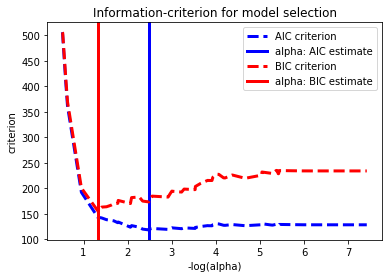

In [19]:
# Your code here 

model_bic = LassoLarsIC(criterion='bic')

model_bic.fit(df_inter, y)

alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(df_inter, y)
alpha_aic_ = model_aic.alpha_


def plot_ic_criterion(model, name, color):
    alpha_ = model.alpha_ 
    alphas_ = model.alphas_ 
    criterion_ = model.criterion_
    plt.plot(-np.log10(alphas_), criterion_, '--', color=color,
             linewidth=3, label='%s criterion' % name)
    plt.axvline(-np.log10(alpha_), color=color, linewidth=3,
                label='alpha: %s estimate' % name)
    plt.xlabel('-log(alpha)')
    plt.ylabel('criterion')


plt.figure()
plot_ic_criterion(model_aic, 'AIC', 'b')
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()
plt.title('Information-criterion for model selection')

## Analyze the final result

Finally, use the best value for the regularization parameter according to AIC and BIC, and compare R-squared and MSE using train-test split. Compare with the baseline model.

In [21]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

In [25]:
# Split X_scaled and y into training and test sets
# Set random_state to 1
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=1)

# Code for baseline model
linreg_all = LinearRegression()
linreg_all.fit(X_train, y_train)


# Print R2 and MSE
print('Training r^2:', linreg_all.score(X_train, y_train))
print('Test r^2:', linreg_all.score(X_test, y_test))
print('Training MSE:', mean_squared_error(y_train, linreg_all.predict(X_train)))
print('Test MSE:', mean_squared_error(y_test, linreg_all.predict(X_test)))

Training r^2: 0.7168057552393374
Test r^2: 0.7789410172622858
Training MSE: 22.477983821877896
Test MSE: 21.897765396049493


In [26]:
# Split df_inter and y into training and test sets
# Set random_state to 1
X_train, X_test, y_train, y_test = train_test_split(df_inter, y, random_state=1)

# Code for lasso with alpha from AIC
lasso = Lasso(alpha=model_aic.alpha_)
lasso.fit(X_train, y_train)


# Print R2 and MSE
print('Training r^2:', lasso.score(X_train, y_train))
print('Test r^2:', lasso.score(X_test, y_test))
print('Training MSE:', mean_squared_error(y_train, lasso.predict(X_train)))
print('Test MSE:', mean_squared_error(y_test, lasso.predict(X_test)))

Training r^2: 0.8155720603121368
Test r^2: 0.8648860563031304
Training MSE: 14.63860343669635
Test MSE: 13.384181018871205


In [27]:
# Code for lasso with alpha from BIC
lasso = Lasso(alpha=model_bic.alpha_)
lasso.fit(X_train, y_train)


# Print R2 and MSE
print('Training r^2:', lasso.score(X_train, y_train))
print('Test r^2:', lasso.score(X_test, y_test))
print('Training MSE:', mean_squared_error(y_train, lasso.predict(X_train)))
print('Test MSE:', mean_squared_error(y_test, lasso.predict(X_test)))

Training r^2: 0.807489057780076
Test r^2: 0.8775992537339207
Training MSE: 15.280175797396735
Test MSE: 12.124831087349008


## Level up (Optional)

### Create a Lasso path

From this section, you know that when using lasso, more parameters shrink to zero as your regularization parameter goes up. In Scikit-learn there is a function `lasso_path()` which visualizes the shrinkage of the coefficients while $alpha$ changes. Try this out yourself!

https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html#sphx-glr-auto-examples-linear-model-plot-lasso-coordinate-descent-path-py

### AIC and BIC for subset selection
This notebook shows how you can use AIC and BIC purely for feature selection. Try this code out on our Boston housing data!

https://xavierbourretsicotte.github.io/subset_selection.html

## Summary

Congratulations! You now know how to create better linear models and how to use AIC and BIC for both feature selection and to optimize your regularization parameter when performing Ridge and Lasso. 